In [24]:
!pip install lightgbm

In [102]:
import lightgbm as lgb
import seaborn as sns
import numpy as np
import pandas as pd
import math
import csv
import matplotlib.pyplot as plt

# Import Training set and Test set of Titanic Passengers

In [103]:
whole_train_set = pd.read_csv('train.csv')
whole_test_set = pd.read_csv('test.csv')

print('Shape of train set', whole_train_set.shape)
print('Shape of test set', whole_test_set.shape)

print('--- Null Data on train set ---\n', whole_train_set.isnull().sum())
print('--- Null Data on test set ---\n', whole_test_set.isnull().sum())

Shape of train set (891, 12)
Shape of test set (418, 11)
--- Null Data on train set ---
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--- Null Data on test set ---
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


# Cleanse Data

In [104]:
# drop passengers ID
drop_col = ['PassengerId', 'Ticket']
train_drop_set = whole_train_set.drop(drop_col, axis = 1)
test_drop_set = whole_test_set.drop(drop_col, axis = 1)

print(train_drop_set)

     Survived  Pclass                                               Name  \
0           0       3                            Braund, Mr. Owen Harris   
1           1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2           1       3                             Heikkinen, Miss. Laina   
3           1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4           0       3                           Allen, Mr. William Henry   
5           0       3                                   Moran, Mr. James   
6           0       1                            McCarthy, Mr. Timothy J   
7           0       3                     Palsson, Master. Gosta Leonard   
8           1       3  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)   
9           1       2                Nasser, Mrs. Nicholas (Adele Achem)   
10          1       3                    Sandstrom, Miss. Marguerite Rut   
11          1       1                           Bonnell, Miss. Elizabeth   
12          

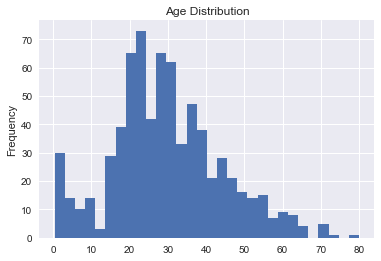

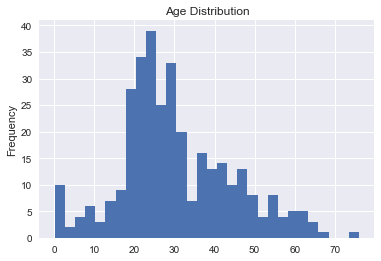

In [105]:
## plot age distribution
%matplotlib inline
age_train_data = train_drop_set.loc[np.logical_not(train_drop_set.Age.isnull()),'Age']
age_test_data = test_drop_set.loc[np.logical_not(test_drop_set.Age.isnull()), 'Age']

fig = plt.figure()
age_train_data.plot.hist(bins = 30)
plt.title('Age Distribution')

fig = plt.figure()
age_test_data.plot.hist(bins = 30)
plt.title('Age Distribution')

## drop age due to too many missing age
train_drop_age_set = train_drop_set.drop(['Age'], axis = 1)
test_drop_age_set = test_drop_set.drop(['Age'], axis = 1)

In [106]:
## Deal with missing value of cabin
## missing value mean that this person don't have cabin to stay.
train_cabin_set = train_drop_age_set.copy()
train_cabin_set.loc[train_cabin_set.Cabin.isnull(),'Cabin'] = 'N'

test_cabin_set = test_drop_age_set.copy()
test_cabin_set.loc[test_cabin_set.Cabin.isnull(), 'Cabin'] = 'N'

## Deal with room number of categories A, B and the other
train_cabin_set.Cabin = train_cabin_set.Cabin.apply(lambda x: x[0])
test_cabin_set.Cabin = test_cabin_set.Cabin.apply(lambda x: x[0])

print(train_cabin_set.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    2
dtype: int64


In [107]:
## Deal with missing values of Embarked in training set and missing value of Fare in test set
print(train_cabin_set.Embarked.value_counts())
train_set_temp = train_cabin_set.copy()
train_set_temp.loc[train_set_temp.Embarked.isnull(), 'Embarked'] = 'S'

test_set_temp = test_cabin_set.copy()
median = np.median(test_set_temp.loc[np.logical_not(test_set_temp.Fare.isnull()),'Fare'])
test_set_temp.loc[test_set_temp.Fare.isnull(), 'Fare'] = median

print(train_set_temp.isnull().sum())
print(test_set_temp.isnull().sum())

S    644
C    168
Q     77
Name: Embarked, dtype: int64
Survived    0
Pclass      0
Name        0
Sex         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
dtype: int64
Pclass      0
Name        0
Sex         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
dtype: int64


In [113]:
## Convert name features into number feature

# for train set
name_split = train_set_temp['Name'].map(lambda x: x.split(','))
name_split_temp = name_split.map(lambda x: x[1].split('.'))
train_abb_name = name_split_temp.map(lambda x: x[0])
train_abb_name_unique = train_abb_name.unique()

# for test set
name_split = test_set_temp['Name'].map(lambda x: x.split(','))
name_split_temp = name_split.map(lambda x: x[1].split('.'))
test_abb_name = name_split_temp.map(lambda x: x[0])
test_abb_name_unique = test_abb_name.unique()

union_unique = set(list(train_abb_name_unique)).union(set(list(test_abb_name_unique)))

# create convert dict
dict_mr = {}
for i, col in enumerate(union_unique):
    dict_mr[col] = int(i)
print(dict_mr)

train_abb_name_numeric = train_abb_name.map(dict_mr)
test_abb_name_numeric = test_abb_name.map(dict_mr)

train_set_temp['Name_Numeric'] = train_abb_name_numeric
#test_abb_name_numeric[test_abb_name_numeric.isnull()] = 0 
#test_abb_name_numeric = test_abb_name_numeric.map(lambda x : int(x))
test_set_temp['Name_Numeric'] = test_abb_name_numeric

train_drop_name_set = train_set_temp.drop(['Name'], axis = 1)
test_drop_name_set = test_set_temp.drop(['Name'], axis = 1)

print(train_drop_name_set.isnull().sum())

{' Lady': 0, ' Don': 1, ' Dr': 2, ' Dona': 3, ' Miss': 4, ' Rev': 5, ' Col': 6, ' Mme': 7, ' Major': 8, ' Capt': 9, ' Mrs': 10, ' Mr': 11, ' Mlle': 12, ' Sir': 13, ' the Countess': 14, ' Master': 15, ' Jonkheer': 16, ' Ms': 17}
Survived        0
Pclass          0
Sex             0
SibSp           0
Parch           0
Fare            0
Cabin           0
Embarked        0
Name_Numeric    0
dtype: int64


In [140]:
## convert all category features into dummies feature
train_set_copy = train_drop_name_set.copy()
test_set_copy = test_drop_name_set.copy()

col_indicator = ['Pclass', 'Name_Numeric', 'Sex', 'SibSp', 'Parch', 'Cabin', 'Embarked']

for col in col_indicator:
    train_set_copy = pd.get_dummies(train_set_copy, columns = [col])
    test_set_copy = pd.get_dummies(test_set_copy, columns = [col])
    
## Number of headers in train and test set are not equal.
## This has to be resolve

all_header = set(list(train_set_copy)).union(set(list(test_set_copy)))

for col in all_header:
    
    if col not in list(train_set_copy):
        train_set_copy[col] = np.zeros(train_set_copy.loc[:,list(train_set_copy)[0]].shape)
    elif col not in list(test_set_copy):
        test_set_copy[col] = np.zeros(test_set_copy.loc[:,list(test_set_copy)[0]].shape)

## sort index 
train_set_copy.sort_index(axis = 1, inplace = True)
test_set_copy.sort_index(axis = 1, inplace = True)
print('train features\n',train_set_copy.isnull().sum())
print('test features\n',test_set_copy.isnull().sum())

train features
 Cabin_A            0
Cabin_B            0
Cabin_C            0
Cabin_D            0
Cabin_E            0
Cabin_F            0
Cabin_G            0
Cabin_N            0
Cabin_T            0
Embarked_C         0
Embarked_Q         0
Embarked_S         0
Fare               0
Name_Numeric_0     0
Name_Numeric_1     0
Name_Numeric_10    0
Name_Numeric_11    0
Name_Numeric_12    0
Name_Numeric_13    0
Name_Numeric_14    0
Name_Numeric_15    0
Name_Numeric_16    0
Name_Numeric_17    0
Name_Numeric_2     0
Name_Numeric_3     0
Name_Numeric_4     0
Name_Numeric_5     0
Name_Numeric_6     0
Name_Numeric_7     0
Name_Numeric_8     0
Name_Numeric_9     0
Parch_0            0
Parch_1            0
Parch_2            0
Parch_3            0
Parch_4            0
Parch_5            0
Parch_6            0
Parch_9            0
Pclass_1           0
Pclass_2           0
Pclass_3           0
Sex_female         0
Sex_male           0
SibSp_0            0
SibSp_1            0
SibSp_2           

mean test 0.05070003046569588
std test 1.0180356352070383


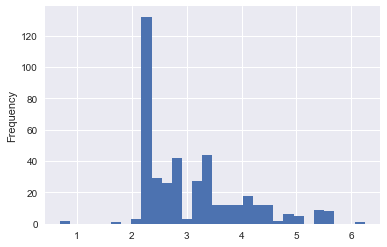

In [196]:
## Normalize Fare feature
train_set_normalize = train_set_copy.copy()
test_set_normalize = test_set_copy.copy()

min_no_zero = np.min(train_set_normalize.loc[train_set_normalize.Fare > 0, 'Fare'])

lamb = min_no_zero/2

train_set_normalize.Fare = train_set_normalize.Fare.apply(lambda x : np.log(x + lamb))
test_set_normalize.Fare = test_set_normalize.Fare.apply(lambda x : np.log(x + lamb))

'''
lamb = 0.3
train_set_normalize.Fare = train_set_normalize.Fare.apply(lambda x : (x**lamb - 1)/lamb)
test_set_normalize.Fare = test_set_normalize.Fare.apply(lambda x : (x**lamb - 1)/lamb)
'''
mean_train = np.mean(train_set_normalize.Fare)
std_train = np.std(train_set_normalize.Fare)

fig = plt.figure()
test_set_normalize.Fare.plot.hist(bins = 30)

## Begin normalize features
test_set_normalize.Fare = (test_set_normalize.Fare - mean_train)/std_train
train_set_normalize.Fare = (train_set_normalize.Fare - mean_train)/std_train

print('mean test', np.mean(test_set_normalize.Fare))
print('std test', np.std(test_set_normalize.Fare))

# Light Gradient Boost Tree Decision

In [193]:
from sklearn.metrics import accuracy_score

1.0

In [243]:
## Extract survived featrue from train set
train_set_extract = train_set_normalize.drop(['Survived'], axis = 1)
test_set_extract = test_set_normalize.drop(['Survived'], axis = 1)

X = train_set_extract.as_matrix().T
X_test = test_set_extract.as_matrix().T
Y = train_set_normalize.Survived.as_matrix()

print('X_train shape', X.shape)
print('X_test shape', X_test.shape)
print('Y_train shape', Y.shape)


X_train shape (51, 891)
X_test shape (51, 418)
Y_train shape (891,)


In [417]:
## simple split train data to 80/20
ratio = 0.9

m = X.shape[1]
X_train = X[:, 0:round(ratio*m)]
X_dev = X[:,round(ratio*m):]

Y_train = Y[0:round(ratio*m)]
Y_dev = Y[round(ratio*m):]

print('total samples of splited data', X_train.shape[1] + X_dev.shape[1])

total samples of splited data 891


In [428]:
## specify lgb

lgb_train = lgb.Dataset(X_train.T, Y_train.T)
lgb_eval = lgb.Dataset(X_dev.T, Y_dev.T, reference=lgb_train)

# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'l2','binary_logloss'},
    'num_leaves': 100,
    'learning_rate': 0.02,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [429]:
## Train lgb model
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=400,
                valid_sets=lgb_eval,
               verbose_eval = False)

In [430]:
y_pred = gbm.predict(X_test.T, num_iteration=gbm.best_iteration)
# eval
Y_pred = np.array([round(x) for x in y_pred])
dic = {'Survived':Y_pred}

output = pd.DataFrame(dic)
output.to_csv('Output.csv')

print(dic)
#print('The accuracy of prediction is:', accuracy_score(Y_dev, Y_pred))

#print('Feature importances:', list(gbm.feature_importance()))

{'Survived': array([ 0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,
        0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,
        1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
        1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
        1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,
        1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,
        0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,
        0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,
        1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
        1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,

# Random Split Test set

In [352]:
def random_split(X,Y, num_fold = 10):
    
    '''
    Split X and Y to num_fold
    
    '''
    
    m = X.shape[1]
    X_temp = X.copy()
    Y_temp = Y.copy()
    
    permute_index = np.random.permutation(m)
    
    X_temp = X_temp[:, permute_index]
    Y_temp = Y_temp[permute_index]
    
    X_fold = np.array_split(X_temp, num_fold, axis = 1)
    Y_fold = np.array_split(Y_temp, num_fold)
    
    X_out = []
    Y_out = []
    
    for i in range(num_fold):
        X_dev_out = X_fold[i]
        Y_dev_out = Y_fold[i]
        
        count = 0
        for k in range(num_fold):
            
            if k != i:
                count += 1
                if count == 1:
                    X_train_out = X_fold[k]
                    Y_train_out = Y_fold[k]
                else:
                    X_train_out = np.concatenate((X_train_out, X_fold[k]), axis = 1)
                    Y_train_out = np.concatenate((Y_train_out, Y_fold[k]))
    
        X_out.append((X_train_out, X_dev_out))
        Y_out.append((Y_train_out.reshape(1, len(Y_train_out)), Y_dev_out.reshape(1, len(Y_dev_out))))
    
    return X_out, Y_out

In [353]:
X_fold, Y_fold = random_split(X, Y)
print(X_fold[0][0].shape)
print(Y_fold[0][1].shape)

(51, 801)
(1, 90)


In [411]:
def cross_validate(X, Y, num_fold = 10, num_hyper = 10, print_cost = True):
    
    X_fold, Y_fold = random_split(X, Y, num_fold = num_fold)
    
    result_validate = pd.DataFrame({})
    num_leaves = np.round(np.random.rand(num_hyper,1)*200 + 31)
    print(num_leaves)
    
    for k in range(num_hyper):
        
        dev_acc = []
        dic = {}
        nn = int(num_leaves[k])
        print(nn)
        
        for i in range(num_fold):

            X_train = X_fold[i][0]
            X_dev = X_fold[i][1]

            Y_train = np.squeeze(Y_fold[i][0])
            Y_dev = np.squeeze(Y_fold[i][1])

            lgb_train = lgb.Dataset(X_train.T, Y_train.T)
            lgb_eval = lgb.Dataset(X_dev.T, Y_dev.T, reference=lgb_train)

            # specify your configurations as a dict
            params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': {'l2','binary_logloss'},
                'num_leaves': nn,
                'learning_rate': 0.02,
                'feature_fraction': 0.9,
                'bagging_fraction': 0.8,
                'bagging_freq': 5,
                'verbose': 0
            }

            gbm = lgb.train(params,
                            lgb_train,
                            num_boost_round=400,
                            valid_sets=lgb_eval,
                            verbose_eval = False)

            y_pred = gbm.predict(X_dev.T, num_iteration=gbm.best_iteration)
            Y_pred = np.array([round(x) for x in y_pred])

            dev_acc.append(accuracy_score(Y_dev, Y_pred))

            if print_cost:
                print('-- round ' + str(i) +' --')
                print('The accuracy of prediction is:', accuracy_score(Y_dev, Y_pred))

        mean = np.mean(dev_acc)
        std = np.std(dev_acc)
        dev_acc.append(mean)
        dev_acc.append(std)

        dic['model_' + str(k)] = dev_acc

        result_validate = pd.concat([result_validate, pd.DataFrame(dic)], axis = 1, ignore_index = True)
        print(result_validate)
    
    ## Create row index
    row_dic = {}
    row_index = []
    for i in range(num_fold):
        row_index.append('fold_'+str(i))
    
    row_index.append('mean')
    row_index.append('std')
    
    row_dic['fold'] = row_index
    
    result_validate = pd.concat([pd.DataFrame(row_dic), result_validate], axis = 1)
    result_validate.set_index('fold')
    
    print(result_validate)
    
    return result_validate

In [412]:
cross_validate(X, Y, num_fold = 10, num_hyper = 10, print_cost = False)

[[ 108.]
 [ 158.]
 [  32.]
 [ 147.]
 [ 178.]
 [ 219.]
 [ 161.]
 [ 133.]
 [ 102.]
 [  61.]]
108
           0
0   0.877778
1   0.764045
2   0.853933
3   0.820225
4   0.764045
5   0.853933
6   0.764045
7   0.853933
8   0.853933
9   0.820225
10  0.822609
11  0.041556
158
           0         1
0   0.877778  0.877778
1   0.764045  0.764045
2   0.853933  0.853933
3   0.820225  0.820225
4   0.764045  0.764045
5   0.853933  0.853933
6   0.764045  0.764045
7   0.853933  0.853933
8   0.853933  0.853933
9   0.820225  0.820225
10  0.822609  0.822609
11  0.041556  0.041556
32
           0         1         2
0   0.877778  0.877778  0.877778
1   0.764045  0.764045  0.764045
2   0.853933  0.853933  0.853933
3   0.820225  0.820225  0.820225
4   0.764045  0.764045  0.764045
5   0.853933  0.853933  0.853933
6   0.764045  0.764045  0.764045
7   0.853933  0.853933  0.853933
8   0.853933  0.853933  0.853933
9   0.820225  0.820225  0.820225
10  0.822609  0.822609  0.822609
11  0.041556  0.041556  0.041556
1

KeyboardInterrupt: 